In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_rows', 100)
    
root_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/'
data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/'

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/model_training/')
from ensemble_train import prepare_mri_predictions

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/model_evaluation/')
from ensemble_evaluation import calculate_rocs_on_datasets,calculate_metrics_on_datasets
from base_evaluation import *

In [2]:
def datasets_sizes(df,datasets,label='MACRO_GROUP'):

    df_size = pd.DataFrame(columns=['Set','Total Samples','Positive Samples','Negative Samples','Positive Percentage'])
    df_size['Set'] = ['Train','Validation','Test','TOTAL']

    df_size.loc[df_size['Set'] == 'Train','Total Samples'] = datasets[0].shape[0]
    df_size.loc[df_size['Set'] == 'Validation','Total Samples'] = datasets[1].shape[0]
    df_size.loc[df_size['Set'] == 'Test','Total Samples'] = datasets[2].shape[0]
    df_size.loc[df_size['Set'] == 'TOTAL','Total Samples'] = df.shape[0]

    df_size.loc[df_size['Set'] == 'Train','Negative Samples'] = datasets[0].query(f"{label} == 0").shape[0]
    df_size.loc[df_size['Set'] == 'Train','Positive Samples'] = datasets[0].query(f"{label} == 1").shape[0]
    df_size.loc[df_size['Set'] == 'Validation','Negative Samples'] = datasets[1].query(f"{label} == 0").shape[0]
    df_size.loc[df_size['Set'] == 'Validation','Positive Samples'] = datasets[1].query(f"{label} == 1").shape[0]
    df_size.loc[df_size['Set'] == 'Test','Negative Samples'] = datasets[2].query(f"{label} == 0").shape[0]
    df_size.loc[df_size['Set'] == 'Test','Positive Samples'] = datasets[2].query(f"{label} == 1").shape[0]
    df_size.loc[df_size['Set'] == 'TOTAL','Negative Samples'] = df.query(f"{label} == 0").shape[0]
    df_size.loc[df_size['Set'] == 'TOTAL','Positive Samples'] = df.query(f"{label} == 1").shape[0]

    df_size['Positive Percentage'] = df_size['Positive Samples'] / df_size['Total Samples']
    df_size['Positive Percentage'] = np.ceil(1000*df_size['Positive Percentage']) / 10
    return df_size

def plot_metric_performance(df,metric,metric_label,experiment_name = 'AD x CN'):
    df.sort_values(metric,ascending=False,inplace=True)

    large_figure = (8,10)
    plt.figure(figsize = large_figure)
    sns.set_color_codes('deep')
    sns.barplot(data=df_test,x=metric,y='Model',color='b')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(metric_label,x=0.25)
    plt.grid(True)
    plt.title(f"{experiment_name} - Comparing {metric_label} between all experiments",fontdict={'size':20},x=0.25)
    plt.show()

# Ensemble Learning Training Results

## AD x CN

In [3]:
df_preds = pd.read_csv(data_path+'PREDICTIONS_AD_ALL_SCORES_ENSEMBLE.csv')
df_preds.columns = df_preds.columns.str.upper()
datasets = [df_preds.query("DATASET in ('train','train_cnn')"),
            df_preds.query("DATASET == 'validation'"),
            df_preds.query("DATASET == 'test'")]

### Dataset size

In [4]:
df_size = datasets_sizes(df_preds,datasets,label='DIAGNOSIS')
print("Preprocessed MRI dataset - AD x CN:")
df_size

Preprocessed MRI dataset - AD x CN:


,Set,Total Samples,Positive Samples,Negative Samples,Positive Percentage
0,Train,709,155,554,21.9
1,Validation,346,73,273,21.1
2,Test,348,65,283,18.7
3,TOTAL,1403,293,1110,20.9


### ROC Curves

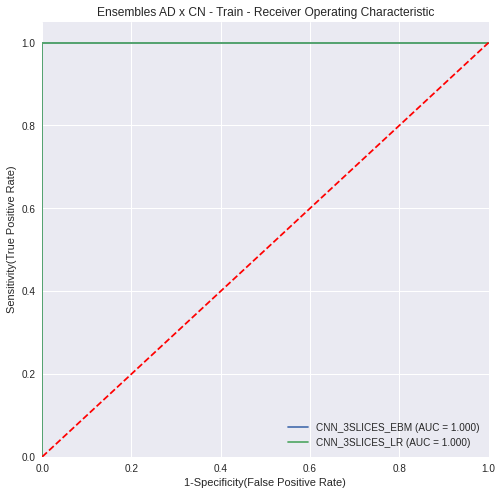

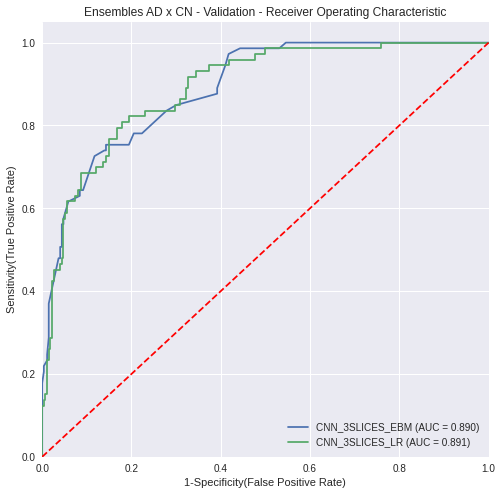

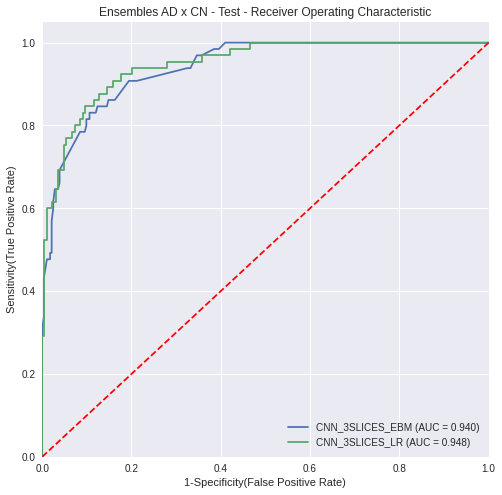

,index,SensLevel_at_0.75,SensLevel_at_0.9,AUC,AUC_CI_low,AUC_CI_high,Std_Error,Optimal_Sen,Sen_CI_low,Sen_CI_high,Optimal_Spe,Spe_CI_low,Spe_CI_high,Model,Optimal_Thresh,set
0,CNN_3SLICES_EBM,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_EBM,0.999761,Train
1,CNN_3SLICES_LR,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_LR,0.945592,Train
2,CNN_3SLICES_EBM,0.8073059360730593,0.6708414872798434,0.889708,0.83895,0.940467,0.025898,0.753425,0.654549,0.8523,0.857143,0.815633,0.898653,CNN_3SLICES_EBM,0.014111,Validation
3,CNN_3SLICES_LR,0.8356164383561644,0.684931506849315,0.890812,0.840273,0.941352,0.025786,0.808219,0.717904,0.898535,0.820513,0.774989,0.866036,CNN_3SLICES_LR,0.076789,Validation
4,CNN_3SLICES_EBM,0.9180288461538462,0.8153846153846154,0.940391,0.899726,0.981057,0.020748,0.846154,0.75844,0.933868,0.876325,0.837969,0.914681,CNN_3SLICES_EBM,0.014111,Test
5,CNN_3SLICES_LR,0.9384615384615385,0.8461538461538461,0.94754,0.909229,0.985851,0.019547,0.876923,0.797056,0.95679,0.872792,0.83397,0.911613,CNN_3SLICES_LR,0.076789,Test


In [5]:
models = ['CNN_3SLICES_EBM', 'CNN_3SLICES_LR']
df_rocs = calculate_rocs_on_datasets(models = models,datasets=datasets,label ='DIAGNOSIS',roc_title_prefix='Ensembles AD x CN - ')
df_rocs

In [6]:
check_auc_difference(models,datasets,label='DIAGNOSIS',alpha=0.05)

Comparing AUCs between CNN_3SLICES_EBM and CNN_3SLICES_LR:
set: Validation
 p-value = 0.9046
 Cannot reject null hypothesis. AUCs are statistically the same.

set: Test
 p-value = 0.3593
 Cannot reject null hypothesis. AUCs are statistically the same.

------------------------------------------


,CNN_3SLICES_EBM,CNN_3SLICES_LR
CNN_3SLICES_EBM,NaN,0.3593
CNN_3SLICES_LR,0.3593,NaN


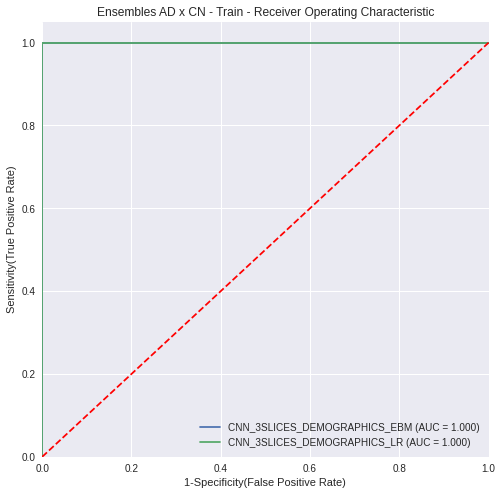

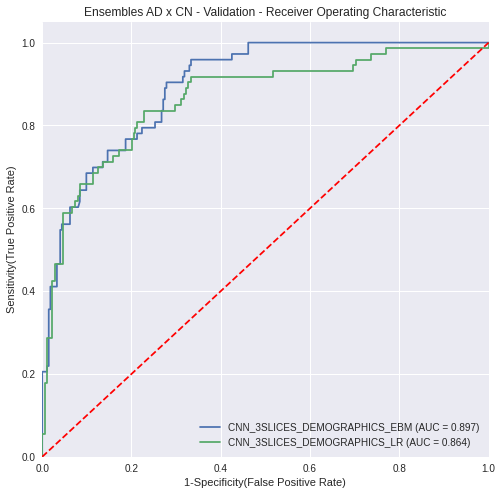

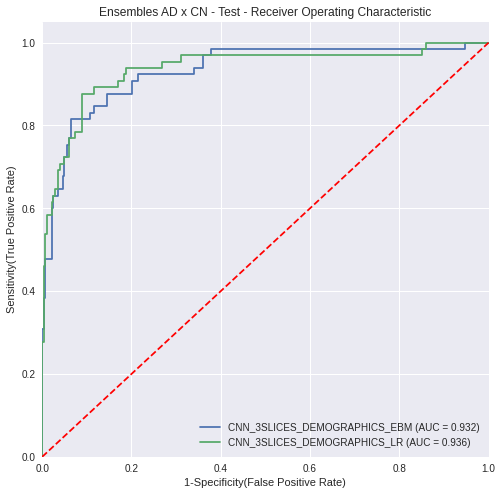

,index,SensLevel_at_0.75,SensLevel_at_0.9,AUC,AUC_CI_low,AUC_CI_high,Std_Error,Optimal_Sen,Sen_CI_low,Sen_CI_high,Optimal_Spe,Spe_CI_low,Spe_CI_high,Model,Optimal_Thresh,set
0,CNN_3SLICES_DEMOGRAPHICS_EBM,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_DEMOGRAPHICS_EBM,0.999982,Train
1,CNN_3SLICES_DEMOGRAPHICS_LR,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_DEMOGRAPHICS_LR,0.952519,Train
2,CNN_3SLICES_DEMOGRAPHICS_EBM,0.7945205479452054,0.684931506849315,0.896758,0.847433,0.946084,0.025167,0.90411,0.836565,0.971655,0.721612,0.668444,0.77478,CNN_3SLICES_DEMOGRAPHICS_EBM,0.000005,Validation
3,CNN_3SLICES_DEMOGRAPHICS_LR,0.8356164383561644,0.6575342465753424,0.864268,0.808874,0.919662,0.028263,0.835616,0.750595,0.920638,0.772894,0.723195,0.822593,CNN_3SLICES_DEMOGRAPHICS_LR,0.048659,Validation
4,CNN_3SLICES_DEMOGRAPHICS_EBM,0.9230769230769231,0.8153846153846154,0.931775,0.888494,0.975056,0.022083,0.876923,0.797056,0.95679,0.855124,0.814115,0.896132,CNN_3SLICES_DEMOGRAPHICS_EBM,0.000005,Test
5,CNN_3SLICES_DEMOGRAPHICS_LR,0.9384615384615385,0.8769230769230769,0.93645,0.89456,0.97834,0.021373,0.876923,0.797056,0.95679,0.911661,0.878597,0.944725,CNN_3SLICES_DEMOGRAPHICS_LR,0.048659,Test


In [7]:
models = ['CNN_3SLICES_DEMOGRAPHICS_EBM',
       'CNN_3SLICES_DEMOGRAPHICS_LR']
df_rocs = calculate_rocs_on_datasets(models = models,datasets=datasets,label ='DIAGNOSIS',roc_title_prefix='Ensembles AD x CN - ')
df_rocs

In [8]:
check_auc_difference(models,datasets,label='DIAGNOSIS',alpha=0.05)

Comparing AUCs between CNN_3SLICES_DEMOGRAPHICS_EBM and CNN_3SLICES_DEMOGRAPHICS_LR:
set: Validation
 p-value = 0.0369
 Refect null hypothesis: AUCs are statistically different with 95% confidence.

set: Test
 p-value = 0.7717
 Cannot reject null hypothesis. AUCs are statistically the same.

------------------------------------------


,CNN_3SLICES_DEMOGRAPHICS_EBM,CNN_3SLICES_DEMOGRAPHICS_LR
CNN_3SLICES_DEMOGRAPHICS_EBM,NaN,0.7717
CNN_3SLICES_DEMOGRAPHICS_LR,0.7717,NaN


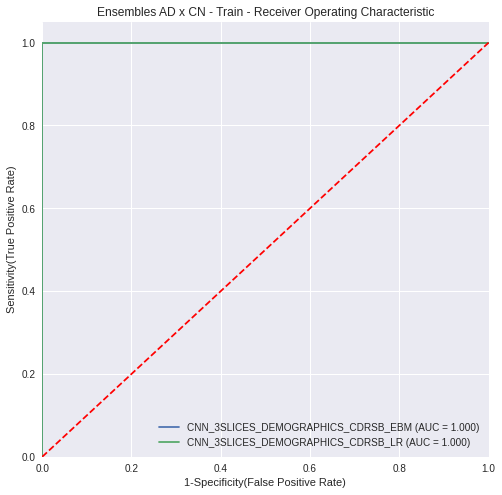

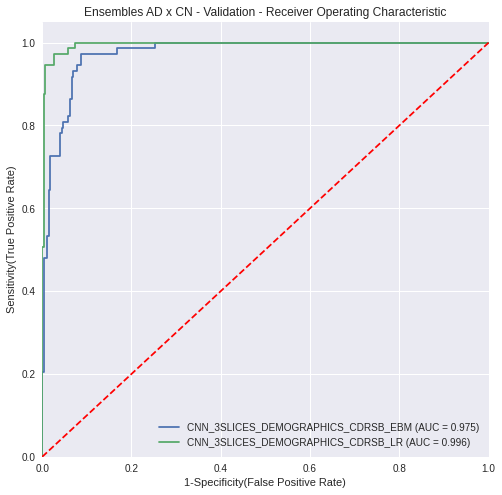

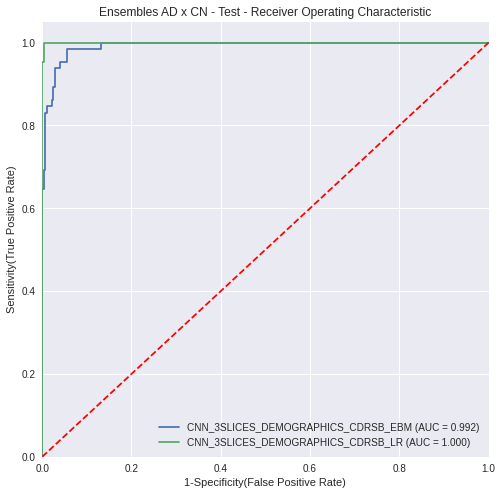

,index,SensLevel_at_0.75,SensLevel_at_0.9,AUC,AUC_CI_low,AUC_CI_high,Std_Error,Optimal_Sen,Sen_CI_low,Sen_CI_high,Optimal_Spe,Spe_CI_low,Spe_CI_high,Model,Optimal_Thresh,set
0,CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,0.999996,Train
1,CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR,0.745986,Train
2,CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,0.9863013698630136,0.9726027397260274,0.97466,0.949118,1.000202,0.013032,0.972603,0.935156,1.01005,0.912088,0.878497,0.945678,CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,0.000240,Validation
3,CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR,1.0,1.0,0.995635,0.98492,1.006349,0.005466,0.972603,0.935156,1.01005,0.974359,0.955609,0.993109,CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR,0.067229,Validation
4,CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,1.0,0.9846153846153847,0.991954,0.976574,1.007335,0.007847,0.984615,0.954694,1.014536,0.943463,0.916554,0.970372,CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,0.000240,Test
5,CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR,1.0,1.0,0.999837,0.997638,1.002036,0.001122,1.0,1.0,1.0,0.996466,0.989553,1.00338,CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR,0.067229,Test


In [9]:
models = ['CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM',
       'CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR']
df_rocs = calculate_rocs_on_datasets(models = models,datasets=datasets,label ='DIAGNOSIS',roc_title_prefix='Ensembles AD x CN - ')
df_rocs

In [10]:
check_auc_difference(models,datasets,label='DIAGNOSIS',alpha=0.05)

Comparing AUCs between CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM and CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR:
set: Validation
 p-value = 0.0001
 Refect null hypothesis: AUCs are statistically different with 95% confidence.

set: Test
 p-value = 0.0153
 Refect null hypothesis: AUCs are statistically different with 95% confidence.

------------------------------------------


,CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR
CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,NaN,0.0153
CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR,0.0153,NaN


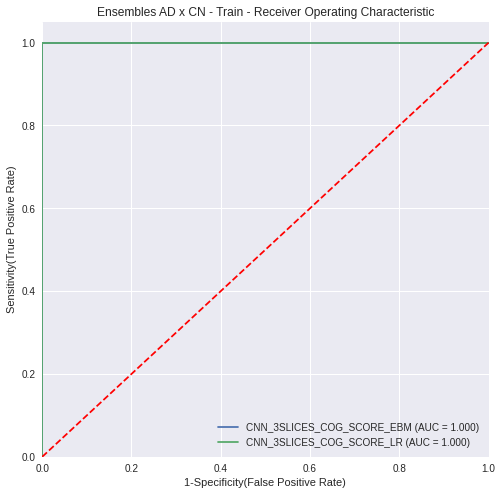

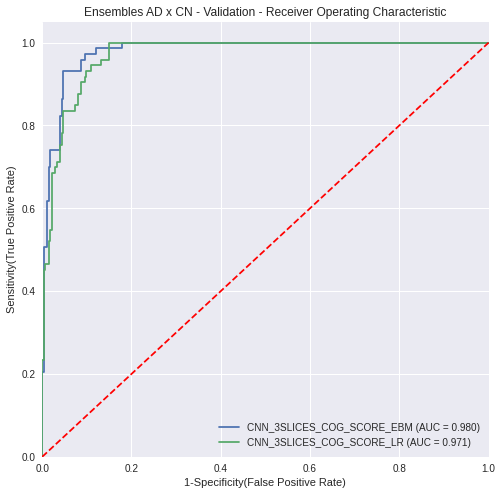

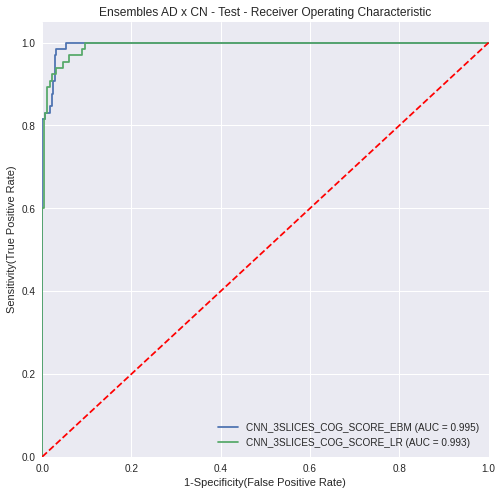

,index,SensLevel_at_0.75,SensLevel_at_0.9,AUC,AUC_CI_low,AUC_CI_high,Std_Error,Optimal_Sen,Sen_CI_low,Sen_CI_high,Optimal_Spe,Spe_CI_low,Spe_CI_high,Model,Optimal_Thresh,set
0,CNN_3SLICES_COG_SCORE_EBM,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_COG_SCORE_EBM,0.999980,Train
1,CNN_3SLICES_COG_SCORE_LR,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_COG_SCORE_LR,0.952712,Train
2,CNN_3SLICES_COG_SCORE_EBM,1.0,0.9726027397260274,0.979527,0.956512,1.002543,0.011743,0.931507,0.873562,0.989451,0.952381,0.927119,0.977643,CNN_3SLICES_COG_SCORE_EBM,0.004938,Validation
3,CNN_3SLICES_COG_SCORE_LR,1.0,0.9315068493150684,0.970696,0.943286,0.998106,0.013985,0.931507,0.873562,0.989451,0.901099,0.865686,0.936512,CNN_3SLICES_COG_SCORE_LR,0.060655,Validation
4,CNN_3SLICES_COG_SCORE_EBM,1.0,1.0,0.995162,0.983214,1.007109,0.006096,0.984615,0.954694,1.014536,0.968198,0.947754,0.988642,CNN_3SLICES_COG_SCORE_EBM,0.004938,Test
5,CNN_3SLICES_COG_SCORE_LR,1.0,1.0,0.992933,0.97851,1.007356,0.007359,0.953846,0.902838,1.004855,0.954064,0.929673,0.978455,CNN_3SLICES_COG_SCORE_LR,0.060655,Test


In [11]:
models = ['CNN_3SLICES_COG_SCORE_EBM', 'CNN_3SLICES_COG_SCORE_LR']
df_rocs = calculate_rocs_on_datasets(models = models,datasets=datasets,label ='DIAGNOSIS',roc_title_prefix='Ensembles AD x CN - ')
df_rocs

In [12]:
check_auc_difference(models,datasets,label='DIAGNOSIS',alpha=0.05)

Comparing AUCs between CNN_3SLICES_COG_SCORE_EBM and CNN_3SLICES_COG_SCORE_LR:
set: Validation
 p-value = 0.0249
 Refect null hypothesis: AUCs are statistically different with 95% confidence.

set: Test
 p-value = 0.2697
 Cannot reject null hypothesis. AUCs are statistically the same.

------------------------------------------


,CNN_3SLICES_COG_SCORE_EBM,CNN_3SLICES_COG_SCORE_LR
CNN_3SLICES_COG_SCORE_EBM,NaN,0.2697
CNN_3SLICES_COG_SCORE_LR,0.2697,NaN


### ROC Curves Comparing all Ensemble Experiments with Best Results

Each ensemble was based on the higher AUC in Validation, regardless if there was a statistical significance.

In [13]:
ensemble_experiments_best = ['CNN_3SLICES_COG_SCORE','CNN_3SLICES', 'CNN_3SLICES_DEMOGRAPHICS','CNN_3SLICES_DEMOGRAPHICS_CDRSB','CDRSB']
all_best_experiments = ['CNN_SCORE_AXIAL_23','CNN_SCORE_CORONAL_43', 'CNN_SCORE_SAGITTAL_26', 'COGTEST_SCORE'] + ensemble_experiments_best

In [14]:
# models = ensemble_experiments_best
# df_rocs = calculate_rocs_on_datasets(models = models,datasets=datasets,label ='DIAGNOSIS',roc_title_prefix='Ensembles AD x CN - ')
# df_rocs

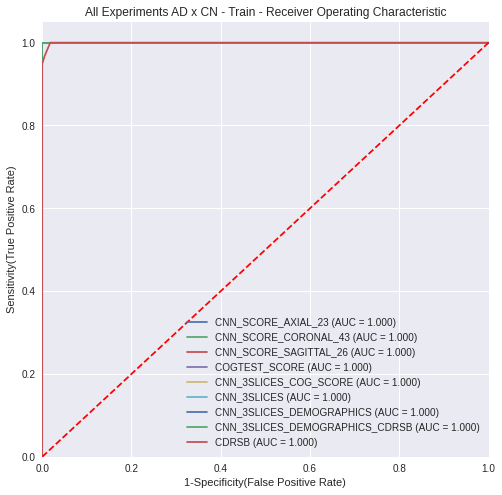

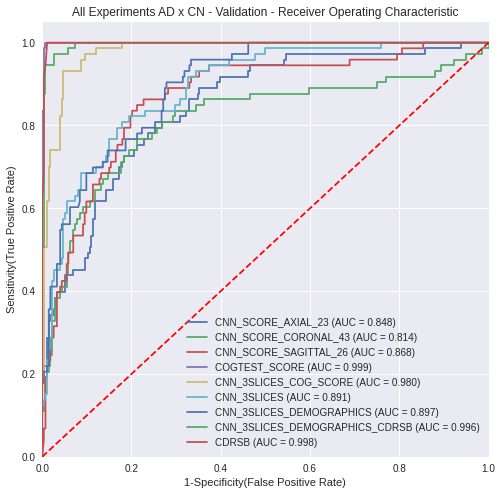

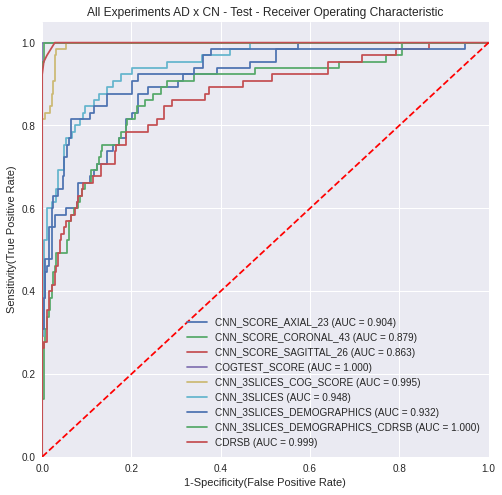

,index,SensLevel_at_0.75,SensLevel_at_0.9,AUC,AUC_CI_low,AUC_CI_high,Std_Error,Optimal_Sen,Sen_CI_low,Sen_CI_high,Optimal_Spe,Spe_CI_low,Spe_CI_high,Model,Optimal_Thresh,set
0,CNN_SCORE_AXIAL_23,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_SCORE_AXIAL_23,0.655753,Train
1,CNN_SCORE_CORONAL_43,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_SCORE_CORONAL_43,0.997879,Train
2,CNN_SCORE_SAGITTAL_26,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_SCORE_SAGITTAL_26,0.999764,Train
3,COGTEST_SCORE,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,COGTEST_SCORE,0.508446,Train
4,CNN_3SLICES_COG_SCORE,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_COG_SCORE,0.999980,Train
5,CNN_3SLICES,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES,0.945592,Train
6,CNN_3SLICES_DEMOGRAPHICS,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_DEMOGRAPHICS,0.999982,Train
7,CNN_3SLICES_DEMOGRAPHICS_CDRSB,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_DEMOGRAPHICS_CDRSB,0.745986,Train
8,CDRSB,1.0,1.0,0.999569,0.997257,1.001881,0.00118,1.0,1.0,1.0,0.981949,0.970863,0.993036,CDRSB,1.500000,Train
9,CNN_SCORE_AXIAL_23,0.7808219178082192,0.4794520547945205,0.848211,0.790261,0.906162,0.029567,0.780822,0.685921,0.875723,0.761905,0.71138,0.812429,CNN_SCORE_AXIAL_23,0.003795,Validation


In [15]:
models = all_best_experiments
df_rocs = calculate_rocs_on_datasets(models = models,datasets=datasets,label ='DIAGNOSIS',roc_title_prefix='All Experiments AD x CN - ')
df_rocs

In [16]:
df_pvalues = check_auc_difference(models,datasets,label='DIAGNOSIS',alpha=0.05,verbose=0)
df_pvalues

,CNN_SCORE_AXIAL_23,CNN_SCORE_CORONAL_43,CNN_SCORE_SAGITTAL_26,COGTEST_SCORE,CNN_3SLICES_COG_SCORE,CNN_3SLICES,CNN_3SLICES_DEMOGRAPHICS,CNN_3SLICES_DEMOGRAPHICS_CDRSB,CDRSB
CNN_SCORE_AXIAL_23,NaN,0.4137,0.2094,0.0,0.0,0.0141,0.1717,0.0,0.0
CNN_SCORE_CORONAL_43,0.4137,NaN,0.6458,0.0,0.0,0.0013,0.0215,0.0,0.0
CNN_SCORE_SAGITTAL_26,0.2094,0.6458,NaN,0.0,0.0,0.0013,0.0158,0.0,0.0
COGTEST_SCORE,0.0,0.0,0.0,NaN,0.0209,0.0001,0.0003,0.3846,0.1528
CNN_3SLICES_COG_SCORE,0.0,0.0,0.0,0.0209,NaN,0.0001,0.0003,0.0256,0.0609
CNN_3SLICES,0.0141,0.0013,0.0013,0.0001,0.0001,NaN,0.1604,0.0001,0.0001
CNN_3SLICES_DEMOGRAPHICS,0.1717,0.0215,0.0158,0.0003,0.0003,0.1604,NaN,0.0004,0.0004
CNN_3SLICES_DEMOGRAPHICS_CDRSB,0.0,0.0,0.0,0.3846,0.0256,0.0001,0.0004,NaN,0.1888
CDRSB,0.0,0.0,0.0,0.1528,0.0609,0.0001,0.0004,0.1888,NaN


### Comparing AUC and F1 between all experiments

In [17]:
df_result_metrics = calculate_metrics_on_datasets(models=all_best_experiments,datasets = datasets,df_rocs=df_rocs,label='DIAGNOSIS',verbose=0)
df_test = df_result_metrics.query("Set == 'Test'").drop(["Conf_Mat",'Set'],axis=1)
df_test = df_test.sort_values(by='Model',key=lambda x: x.map({
                                                'CNN_SCORE_AXIAL_23':0,
                                                'CNN_SCORE_CORONAL_43':1,
                                                'CNN_SCORE_SAGITTAL_26':2,
                                                'CNN_3SLICES':3,
                                                'CNN_3SLICES_COG_SCORE':4,
                                                'CNN_3SLICES_DEMOGRAPHICS':5,
                                                'CNN_3SLICES_DEMOGRAPHICS_CDRSB':6,
                                                'CDRSB':7
                                                }))

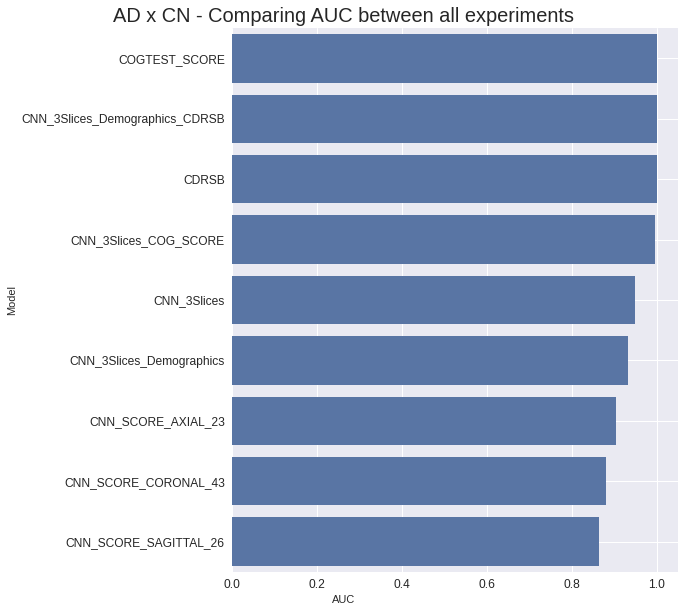

In [200]:
plot_metric_performance(df=df_test,metric='Auc',metric_label='AUC',experiment_name = 'AD x CN')

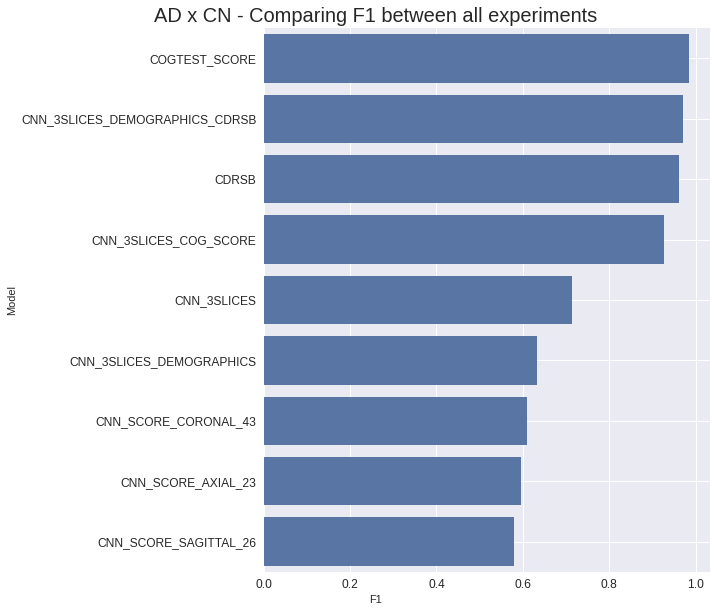

In [18]:
plot_metric_performance(df=df_test,metric='F1Score',metric_label='F1',experiment_name = 'AD x CN')

### Metrics table

In [55]:
df_result_metrics = calculate_metrics_on_datasets(models=ensemble_experiments_best,datasets = datasets,df_rocs=df_rocs,label='DIAGNOSIS',verbose=0)
df_test = df_result_metrics.query("Set == 'Test'").drop(["Conf_Mat",'Set'],axis=1)
df_test

,Model,Auc,F1Score,Accuracy,Precision,Recall,Prediction_Threshold
10,CNN_3Slices_COG_SCORE,0.995,0.926,0.971,0.887,0.969,0.005
11,CNN_3Slices,0.948,0.713,0.871,0.609,0.862,0.077
12,CNN_3Slices_Demographics,0.932,0.632,0.799,0.480,0.923,0.000
13,CNN_3Slices_Demographics_CDRSB,1.000,0.970,0.989,0.942,1.000,0.067
14,CDRSB,0.999,0.962,0.986,0.955,0.969,1.500


In [19]:
df_all_metrics = pd.pivot_table(data=df_result_metrics.drop(['Conf_Mat'],axis=1),index=['Model','Set'])
df_all_metrics = df_all_metrics.sort_index(key=lambda x: x.map({
                                                'CNN_3SLICES':0,
                                                'CNN_3SLICES_COG_SCORE':1,
                                                'CNN_3SLICES_DEMOGRAPHICS':2,
                                                'CNN_3SLICES_DEMOGRAPHICS_CDRSB':3,
                                                'CDRSB':4,
                                                'Train':0,
                                                'Validation':1}))
df_all_metrics

Accuracy    Auc  F1Score  \
Model                          Set                                    
CNN_3SLICES                    Train          1.000  1.000    1.000   
                               Validation     0.818  0.891    0.652   
                               Test           0.871  0.948    0.713   
CNN_3SLICES_COG_SCORE          Train          1.000  1.000    1.000   
                               Validation     0.948  0.980    0.883   
                               Test           0.971  0.995    0.926   
CNN_3SLICES_DEMOGRAPHICS       Train          1.000  1.000    1.000   
                               Validation     0.760  0.897    0.614   
                               Test           0.799  0.932    0.632   
CNN_3SLICES_DEMOGRAPHICS_CDRSB Train          1.000  1.000    1.000   
                               Validation     0.974  0.996    0.940   
                               Test           0.989  1.000    0.970   
CDRSB                          Train          0.986  1.000    0.969   
                               Validation     0.991  0.998    0.980   
                               Test           0.986  0.999    0.962   
CNN_SCORE_AXIAL_23             Train          1.000  1.000    1.000   
CNN_SCORE_CORONAL_43           Train          1.000  1.000    1.000   
CNN_SCORE_SAGITTAL_26          Train          1.000  1.000    1.000   
COGTEST_SCORE                  Train          1.000  1.000    1.000   
CNN_SCORE_AXIAL_23             Validation     0.766  0.848    0.585   
CNN_SCORE_CORONAL_43           Validation     0.783  0.814    0.599   
CNN_SCORE_SAGITTAL_26          Validation     0.806  0.868    0.646   
COGTEST_SCORE                  Validation     0.994  0.999    0.986   
CNN_SCORE_AXIAL_23             Test           0.805  0.904    0.595   
CNN_SCORE_CORONAL_43           Test           0.819  0.879    0.609   
CNN_SCORE_SAGITTAL_26          Test           0.787  0.863    0.580   
COGTEST_SCORE                  Test           0.994  1.000    0.984   

                                           Precision  Prediction_Threshold  \
Model                          Set                                           
CNN_3SLICES                    Train           1.000                 0.946   
                               Validation      0.546                 0.077   
                               Test            0.609                 0.077   
CNN_3SLICES_COG_SCORE          Train           1.000                 1.000   
                               Validation      0.840                 0.005   
                               Test            0.887                 0.005   
CNN_3SLICES_DEMOGRAPHICS       Train           1.000                 1.000   
                               Validation      0.465                 0.000   
                               Test            0.480                 0.000   
CNN_3SLICES_DEMOGRAPHICS_CDRSB Train           1.000                 0.746   
                               Validation      0.910                 0.067   
                               Test            0.942                 0.067   
CDRSB                          Train           0.939                 1.500   
                               Validation      0.961                 1.500   
                               Test            0.955                 1.500   
CNN_SCORE_AXIAL_23             Train           1.000                 0.656   
CNN_SCORE_CORONAL_43           Train           1.000                 0.998   
CNN_SCORE_SAGITTAL_26          Train           1.000                 1.000   
COGTEST_SCORE                  Train           1.000                 0.508   
CNN_SCORE_AXIAL_23             Validation      0.467                 0.004   
CNN_SCORE_CORONAL_43           Validation      0.491                 0.164   
CNN_SCORE_SAGITTAL_26          Validation      0.526                 0.002   
COGTEST_SCORE                  Validation      0.973                 0.620   
CNN_SCORE_AXIAL_23             Te

### Confusion Matrix

In [20]:
for i,item in df_result_metrics.iterrows():
    print(item['Model'] + ' - ' + item['Set'])
    print(pd.DataFrame(item['Conf_Mat']))
    print('---------------------------')

CNN_SCORE_AXIAL_23 - Train
     0    1
0  554    0
1    0  155
---------------------------
CNN_SCORE_CORONAL_43 - Train
     0    1
0  554    0
1    0  155
---------------------------
CNN_SCORE_SAGITTAL_26 - Train
     0    1
0  554    0
1    0  155
---------------------------
COGTEST_SCORE - Train
     0    1
0  554    0
1    0  155
---------------------------
CNN_3SLICES_COG_SCORE - Train
     0    1
0  554    0
1    0  155
---------------------------
CNN_3SLICES - Train
     0    1
0  554    0
1    0  155
---------------------------
CNN_3SLICES_DEMOGRAPHICS - Train
     0    1
0  554    0
1    0  155
---------------------------
CNN_3SLICES_DEMOGRAPHICS_CDRSB - Train
     0    1
0  554    0
1    0  155
---------------------------
CDRSB - Train
     0    1
0  544   10
1    0  155
---------------------------
CNN_SCORE_AXIAL_23 - Validation
     0   1
0  208  65
1   16  57
---------------------------
CNN_SCORE_CORONAL_43 - Validation
     0   1
0  215  58
1   17  56
--------------------

## MCI x CN

In [21]:
df_preds = pd.read_csv(data_path+'PREDICTIONS_MCI_ALL_SCORES_ENSEMBLE.csv')
df_preds.columns = df_preds.columns.str.upper()
datasets = [df_preds.query("DATASET in ('train','train_cnn')"),
            df_preds.query("DATASET == 'validation'"),
            df_preds.query("DATASET == 'test'")]

### Dataset size

In [22]:
df_size = datasets_sizes(df_preds,datasets,label='DIAGNOSIS')
print("Preprocessed MRI dataset - MCI x CN:")
df_size

Preprocessed MRI dataset - MCI x CN:


,Set,Total Samples,Positive Samples,Negative Samples,Positive Percentage
0,Train,715,161,554,22.6
1,Validation,355,82,273,23.1
2,Test,364,81,283,22.3
3,TOTAL,1434,324,1110,22.6


### ROC Curves

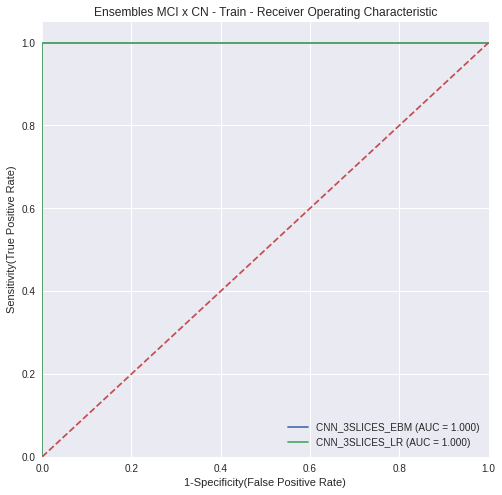

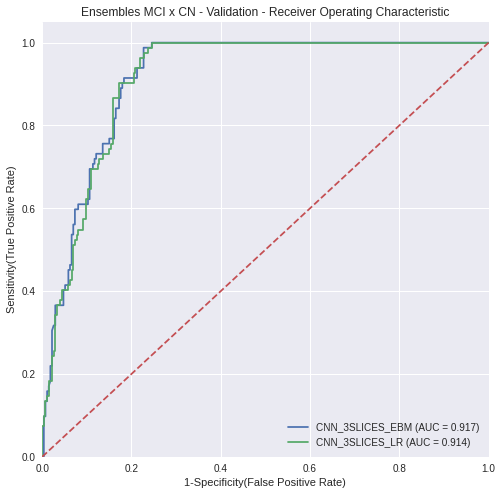

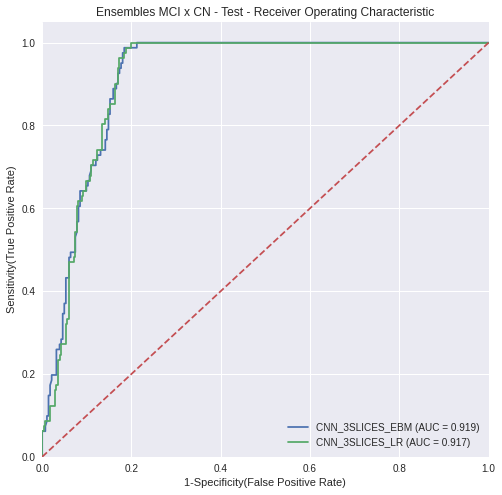

,index,SensLevel_at_0.75,SensLevel_at_0.9,AUC,AUC_CI_low,AUC_CI_high,Std_Error,Optimal_Sen,Sen_CI_low,Sen_CI_high,Optimal_Spe,Spe_CI_low,Spe_CI_high,Model,Optimal_Thresh,set
0,CNN_3SLICES_EBM,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_EBM,0.999075,Train
1,CNN_3SLICES_LR,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_LR,0.664364,Train
2,CNN_3SLICES_EBM,1.0,0.6097560975609756,0.91651,0.874048,0.958973,0.021665,0.914634,0.854154,0.975115,0.81685,0.770967,0.862733,CNN_3SLICES_EBM,0.000736,Validation
3,CNN_3SLICES_LR,1.0,0.6219512195121951,0.913785,0.870702,0.956869,0.021982,0.902439,0.838215,0.966663,0.827839,0.783056,0.872622,CNN_3SLICES_LR,0.305665,Validation
4,CNN_3SLICES_EBM,1.0,0.654320987654321,0.919121,0.877055,0.961186,0.021463,0.975309,0.941513,1.009104,0.819788,0.775006,0.86457,CNN_3SLICES_EBM,0.000736,Test
5,CNN_3SLICES_LR,1.0,0.6666666666666666,0.917027,0.874471,0.959582,0.021712,0.962963,0.921835,1.004091,0.826855,0.782771,0.870939,CNN_3SLICES_LR,0.305665,Test


In [23]:
models = ['CNN_3SLICES_EBM', 'CNN_3SLICES_LR']
df_rocs = calculate_rocs_on_datasets(models = models,datasets=datasets,label ='DIAGNOSIS',roc_title_prefix='Ensembles MCI x CN - ')
df_rocs

In [24]:
check_auc_difference(models,datasets,label='DIAGNOSIS',alpha=0.05)

Comparing AUCs between CNN_3SLICES_EBM and CNN_3SLICES_LR:
set: Validation
 p-value = 0.5708
 Cannot reject null hypothesis. AUCs are statistically the same.

set: Test
 p-value = 0.5886
 Cannot reject null hypothesis. AUCs are statistically the same.

------------------------------------------


,CNN_3SLICES_EBM,CNN_3SLICES_LR
CNN_3SLICES_EBM,NaN,0.5886
CNN_3SLICES_LR,0.5886,NaN


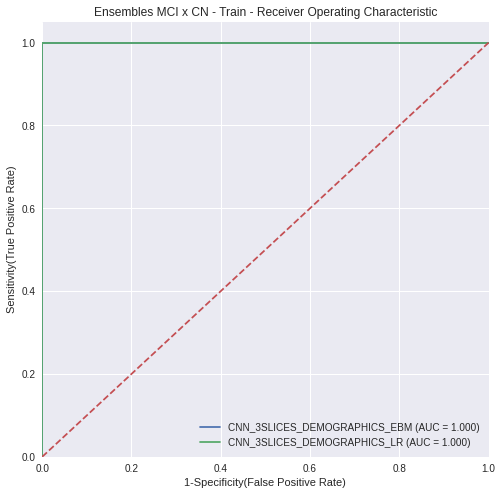

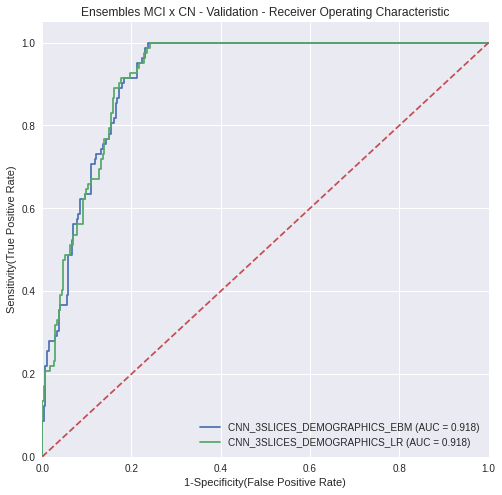

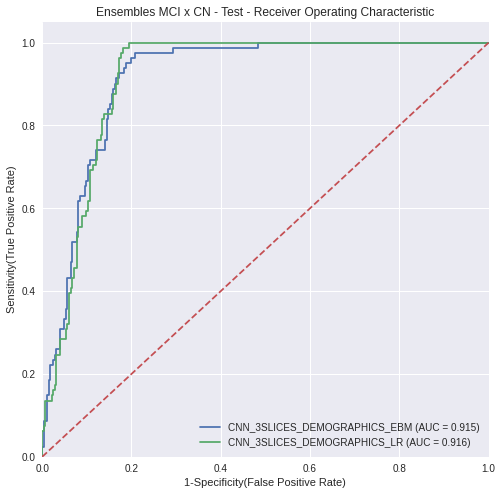

,index,SensLevel_at_0.75,SensLevel_at_0.9,AUC,AUC_CI_low,AUC_CI_high,Std_Error,Optimal_Sen,Sen_CI_low,Sen_CI_high,Optimal_Spe,Spe_CI_low,Spe_CI_high,Model,Optimal_Thresh,set
0,CNN_3SLICES_DEMOGRAPHICS_EBM,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_DEMOGRAPHICS_EBM,0.999998,Train
1,CNN_3SLICES_DEMOGRAPHICS_LR,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_DEMOGRAPHICS_LR,0.602032,Train
2,CNN_3SLICES_DEMOGRAPHICS_EBM,1.0,0.6341463414634146,0.91794,0.875808,0.960071,0.021496,0.914634,0.854154,0.975115,0.81685,0.770967,0.862733,CNN_3SLICES_DEMOGRAPHICS_EBM,0.000006,Validation
3,CNN_3SLICES_DEMOGRAPHICS_LR,1.0,0.6463414634146342,0.918208,0.876139,0.960277,0.021464,0.890244,0.822586,0.957902,0.838828,0.795211,0.882445,CNN_3SLICES_DEMOGRAPHICS_LR,0.355395,Validation
4,CNN_3SLICES_DEMOGRAPHICS_EBM,0.9753086419753086,0.6666666666666666,0.914584,0.871467,0.9577,0.021999,0.91358,0.852388,0.974772,0.833922,0.790563,0.877281,CNN_3SLICES_DEMOGRAPHICS_EBM,0.000006,Test
5,CNN_3SLICES_DEMOGRAPHICS_LR,1.0,0.5925925925925926,0.916023,0.873236,0.958811,0.021831,0.962963,0.921835,1.004091,0.826855,0.782771,0.870939,CNN_3SLICES_DEMOGRAPHICS_LR,0.355395,Test


In [25]:
models = ['CNN_3SLICES_DEMOGRAPHICS_EBM',
       'CNN_3SLICES_DEMOGRAPHICS_LR']
df_rocs = calculate_rocs_on_datasets(models = models,datasets=datasets,label ='DIAGNOSIS',roc_title_prefix='Ensembles MCI x CN - ')
df_rocs

In [26]:
check_auc_difference(models,datasets,label='DIAGNOSIS',alpha=0.05)

Comparing AUCs between CNN_3SLICES_DEMOGRAPHICS_EBM and CNN_3SLICES_DEMOGRAPHICS_LR:
set: Validation
 p-value = 0.9576
 Cannot reject null hypothesis. AUCs are statistically the same.

set: Test
 p-value = 0.8082
 Cannot reject null hypothesis. AUCs are statistically the same.

------------------------------------------


,CNN_3SLICES_DEMOGRAPHICS_EBM,CNN_3SLICES_DEMOGRAPHICS_LR
CNN_3SLICES_DEMOGRAPHICS_EBM,NaN,0.8082
CNN_3SLICES_DEMOGRAPHICS_LR,0.8082,NaN


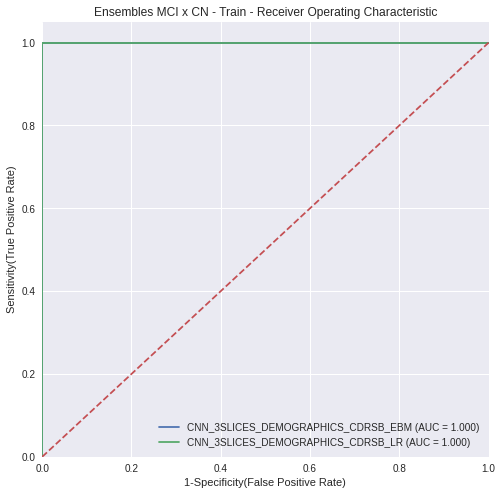

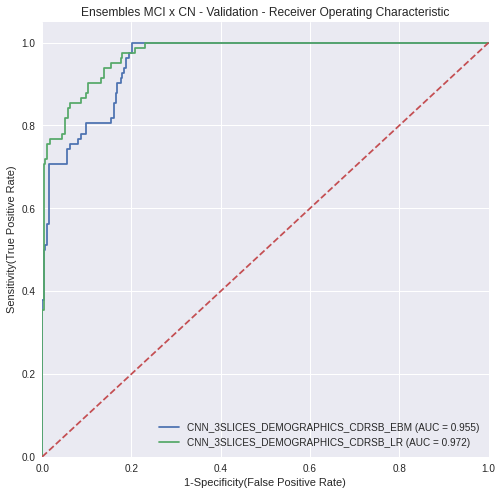

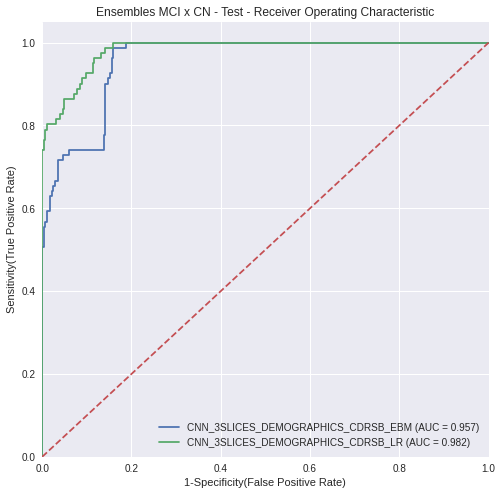

,index,SensLevel_at_0.75,SensLevel_at_0.9,AUC,AUC_CI_low,AUC_CI_high,Std_Error,Optimal_Sen,Sen_CI_low,Sen_CI_high,Optimal_Spe,Spe_CI_low,Spe_CI_high,Model,Optimal_Thresh,set
0,CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,9.999922e-01,Train
1,CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR,3.082720e-01,Train
2,CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,1.0,0.8048780487804879,0.95524,0.923494,0.986986,0.016197,0.963415,0.922779,1.00405,0.813187,0.766952,0.859422,CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,4.720118e-07,Validation
3,CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR,1.0,0.8780487804878049,0.972036,0.946732,0.99734,0.012911,0.902439,0.838215,0.966663,0.897436,0.861447,0.933425,CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR,4.571813e-01,Validation
4,CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,1.0,0.7407407407407407,0.956594,0.925138,0.98805,0.016049,0.987654,0.963607,1.011702,0.840989,0.798383,0.883595,CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,4.720118e-07,Test
5,CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR,1.0,0.9259259259259259,0.982201,0.961795,1.002607,0.010411,0.962963,0.921835,1.004091,0.883392,0.845998,0.920786,CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR,4.571813e-01,Test


In [27]:
models = ['CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM',
       'CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR']
df_rocs = calculate_rocs_on_datasets(models = models,datasets=datasets,label ='DIAGNOSIS',roc_title_prefix='Ensembles MCI x CN - ')
df_rocs

In [28]:
check_auc_difference(models,datasets,label='DIAGNOSIS',alpha=0.05)

Comparing AUCs between CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM and CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR:
set: Validation
 p-value = 0.0040
 Refect null hypothesis: AUCs are statistically different with 95% confidence.

set: Test
 p-value = 0.0001
 Refect null hypothesis: AUCs are statistically different with 95% confidence.

------------------------------------------


,CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR
CNN_3SLICES_DEMOGRAPHICS_CDRSB_EBM,NaN,0.0001
CNN_3SLICES_DEMOGRAPHICS_CDRSB_LR,0.0001,NaN


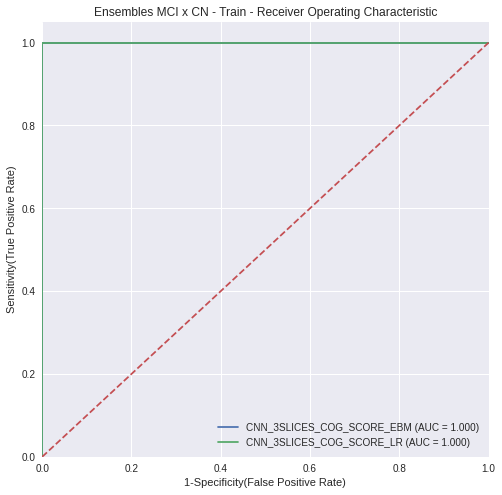

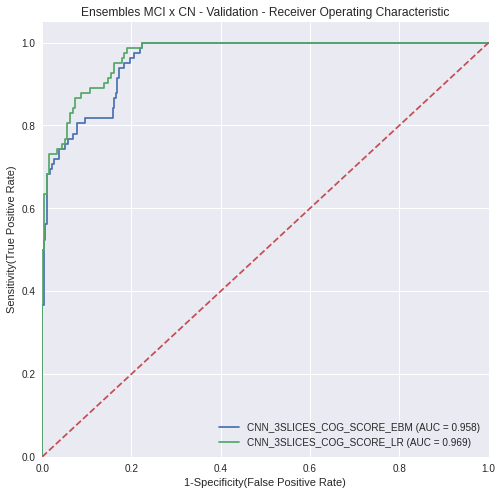

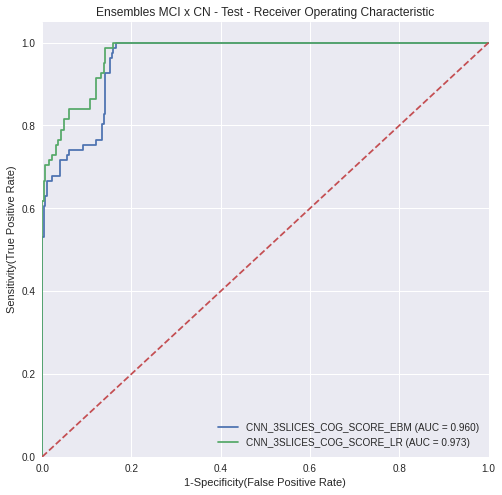

,index,SensLevel_at_0.75,SensLevel_at_0.9,AUC,AUC_CI_low,AUC_CI_high,Std_Error,Optimal_Sen,Sen_CI_low,Sen_CI_high,Optimal_Spe,Spe_CI_low,Spe_CI_high,Model,Optimal_Thresh,set
0,CNN_3SLICES_COG_SCORE_EBM,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_COG_SCORE_EBM,0.999392,Train
1,CNN_3SLICES_COG_SCORE_LR,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_COG_SCORE_LR,0.334613,Train
2,CNN_3SLICES_COG_SCORE_EBM,1.0,0.8170731707317073,0.958188,0.927459,0.988917,0.015678,0.939024,0.887232,0.990817,0.827839,0.783056,0.872622,CNN_3SLICES_COG_SCORE_EBM,0.000296,Validation
3,CNN_3SLICES_COG_SCORE_LR,1.0,0.8780487804878049,0.969401,0.942965,0.995836,0.013488,0.878049,0.807221,0.948876,0.912088,0.878497,0.945678,CNN_3SLICES_COG_SCORE_LR,0.558465,Validation
4,CNN_3SLICES_COG_SCORE_EBM,1.0,0.7530864197530864,0.959517,0.929092,0.989941,0.015523,0.962963,0.921835,1.004091,0.848057,0.806233,0.88988,CNN_3SLICES_COG_SCORE_EBM,0.000296,Test
5,CNN_3SLICES_COG_SCORE_LR,1.0,0.8395061728395061,0.973389,0.948547,0.998232,0.012675,0.987654,0.963607,1.011702,0.858657,0.818068,0.899246,CNN_3SLICES_COG_SCORE_LR,0.558465,Test


In [29]:
models = ['CNN_3SLICES_COG_SCORE_EBM', 'CNN_3SLICES_COG_SCORE_LR']
df_rocs = calculate_rocs_on_datasets(models = models,datasets=datasets,label ='DIAGNOSIS',roc_title_prefix='Ensembles MCI x CN - ')
df_rocs

In [30]:
check_auc_difference(models,datasets,label='DIAGNOSIS',alpha=0.05)

Comparing AUCs between CNN_3SLICES_COG_SCORE_EBM and CNN_3SLICES_COG_SCORE_LR:
set: Validation
 p-value = 0.0013
 Refect null hypothesis: AUCs are statistically different with 95% confidence.

set: Test
 p-value = 0.0005
 Refect null hypothesis: AUCs are statistically different with 95% confidence.

------------------------------------------


,CNN_3SLICES_COG_SCORE_EBM,CNN_3SLICES_COG_SCORE_LR
CNN_3SLICES_COG_SCORE_EBM,NaN,0.0005
CNN_3SLICES_COG_SCORE_LR,0.0005,NaN


### ROC Curves Comparing all Ensemble Experiments with Best Results

Each ensemble was based on the higher AUC in Validation, regardless if there was a statistical significance.

In [31]:
ensemble_experiments_best = ['CNN_3SLICES_COG_SCORE','CNN_3SLICES', 'CNN_3SLICES_DEMOGRAPHICS','CNN_3SLICES_DEMOGRAPHICS_CDRSB','CDRSB']
all_best_experiments = ['CNN_SCORE_AXIAL_8','CNN_SCORE_CORONAL_70', 'CNN_SCORE_SAGITTAL_50', 'COGTEST_SCORE'] + ensemble_experiments_best

In [32]:
# models = ensemble_experiments_best
# df_rocs = calculate_rocs_on_datasets(models = models,datasets=datasets,label ='DIAGNOSIS',roc_title_prefix='Ensembles AD x CN - ')
# df_rocs

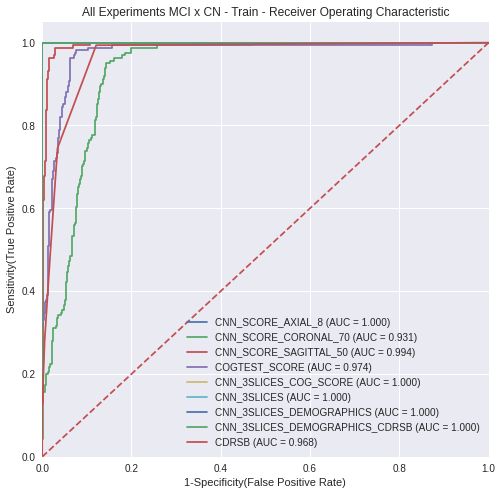

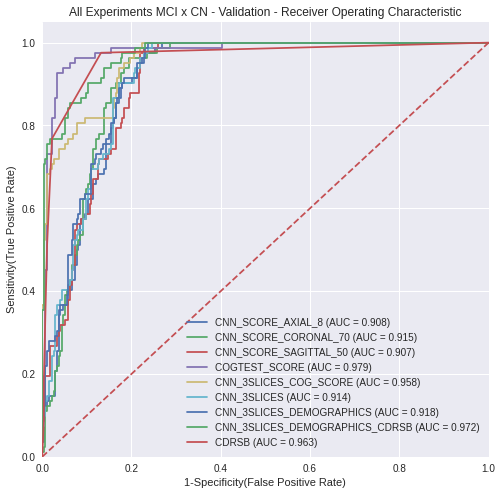

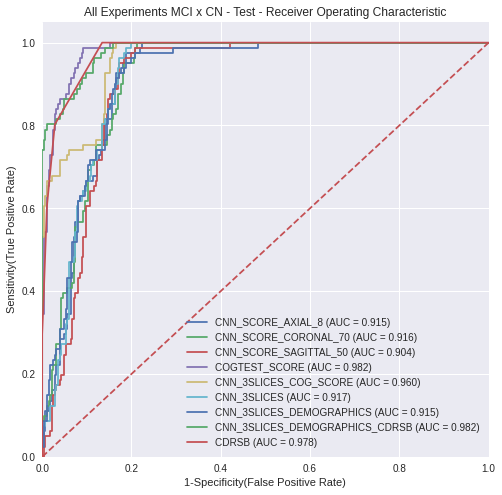

,index,SensLevel_at_0.75,SensLevel_at_0.9,AUC,AUC_CI_low,AUC_CI_high,Std_Error,Optimal_Sen,Sen_CI_low,Sen_CI_high,Optimal_Spe,Spe_CI_low,Spe_CI_high,Model,Optimal_Thresh,set
0,CNN_SCORE_AXIAL_8,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_SCORE_AXIAL_8,0.564833,Train
1,CNN_SCORE_CORONAL_70,0.9875776397515528,0.7453416149068323,0.930881,0.903128,0.958634,0.01416,0.950311,0.916744,0.983877,0.857401,0.828283,0.886518,CNN_SCORE_CORONAL_70,0.441264,Train
2,CNN_SCORE_SAGITTAL_50,1.0,0.9937888198757764,0.994237,0.98596,1.002514,0.004223,0.987578,0.970468,1.004687,0.971119,0.957173,0.985065,CNN_SCORE_SAGITTAL_50,0.518427,Train
3,COGTEST_SCORE,0.9937888198757764,0.9813664596273292,0.973855,0.956397,0.991312,0.008907,0.962733,0.933474,0.991992,0.938628,0.918642,0.958614,COGTEST_SCORE,0.622595,Train
4,CNN_3SLICES_COG_SCORE,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_COG_SCORE,0.999392,Train
5,CNN_3SLICES,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES,0.664364,Train
6,CNN_3SLICES_DEMOGRAPHICS,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_DEMOGRAPHICS,0.999998,Train
7,CNN_3SLICES_DEMOGRAPHICS_CDRSB,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,CNN_3SLICES_DEMOGRAPHICS_CDRSB,0.308272,Train
8,CDRSB,0.9947007282513041,0.9337474120082815,0.967655,0.948298,0.987012,0.009876,0.993789,0.981653,1.005925,0.879061,0.85191,0.906213,CDRSB,0.500000,Train
9,CNN_SCORE_AXIAL_8,0.975609756097561,0.5853658536585366,0.907531,0.863072,0.951991,0.022684,0.902439,0.838215,0.966663,0.820513,0.774989,0.866036,CNN_SCORE_AXIAL_8,0.322333,Validation


In [33]:
models = all_best_experiments
df_rocs = calculate_rocs_on_datasets(models = models,datasets=datasets,label ='DIAGNOSIS',roc_title_prefix='All Experiments MCI x CN - ')
df_rocs

In [34]:
df_pvalues = check_auc_difference(models,datasets,label='DIAGNOSIS',alpha=0.05,verbose=0)
df_pvalues

,CNN_SCORE_AXIAL_8,CNN_SCORE_CORONAL_70,CNN_SCORE_SAGITTAL_50,COGTEST_SCORE,CNN_3SLICES_COG_SCORE,CNN_3SLICES,CNN_3SLICES_DEMOGRAPHICS,CNN_3SLICES_DEMOGRAPHICS_CDRSB,CDRSB
CNN_SCORE_AXIAL_8,NaN,0.9638,0.3733,0.0,0.0,0.4849,0.9202,0.0,0.0
CNN_SCORE_CORONAL_70,0.9638,NaN,0.3954,0.0,0.0005,0.9311,0.9225,0.0,0.0
CNN_SCORE_SAGITTAL_50,0.3733,0.3954,NaN,0.0,0.0,0.2411,0.3451,0.0,0.0
COGTEST_SCORE,0.0,0.0,0.0,NaN,0.0279,0.0,0.0,0.9948,0.09
CNN_3SLICES_COG_SCORE,0.0,0.0005,0.0,0.0279,NaN,0.0,0.0,0.0001,0.0692
CNN_3SLICES,0.4849,0.9311,0.2411,0.0,0.0,NaN,0.6826,0.0,0.0001
CNN_3SLICES_DEMOGRAPHICS,0.9202,0.9225,0.3451,0.0,0.0,0.6826,NaN,0.0,0.0001
CNN_3SLICES_DEMOGRAPHICS_CDRSB,0.0,0.0,0.0,0.9948,0.0001,0.0,0.0,NaN,0.5839
CDRSB,0.0,0.0,0.0,0.09,0.0692,0.0001,0.0001,0.5839,NaN


### Comparing AUC and F1 between all experiments

In [35]:
df_result_metrics = calculate_metrics_on_datasets(models=all_best_experiments,datasets = datasets,df_rocs=df_rocs,label='DIAGNOSIS',verbose=0)
df_test = df_result_metrics.query("Set == 'Test'").drop(["Conf_Mat",'Set'],axis=1)
df_test = df_test.sort_values(by='Model',key=lambda x: x.map({
                                                'CNN_SCORE_AXIAL_23':0,
                                                'CNN_SCORE_CORONAL_43':1,
                                                'CNN_SCORE_SAGITTAL_26':2,
                                                'CNN_3SLICES':3,
                                                'CNN_3SLICES_COG_SCORE':4,
                                                'CNN_3SLICES_DEMOGRAPHICS':5,
                                                'CNN_3SLICES_DEMOGRAPHICS_CDRSB':6,
                                                'CDRSB':7
                                                }))

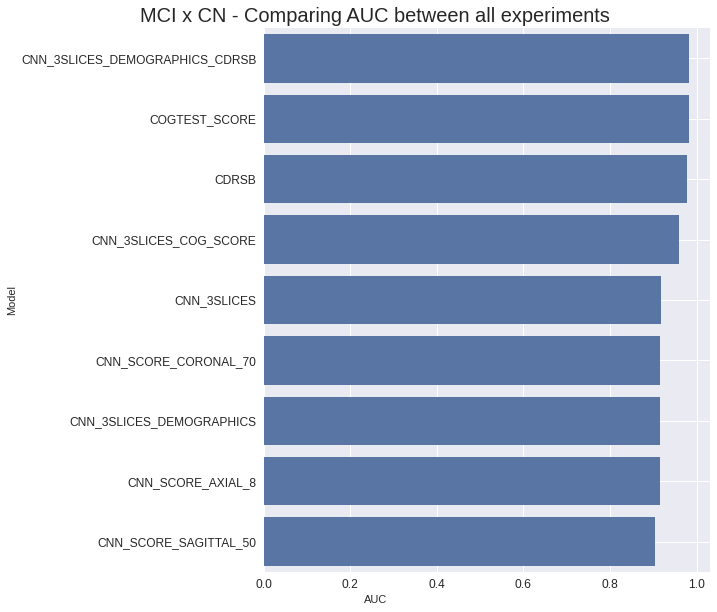

In [36]:
plot_metric_performance(df=df_test,metric='Auc',metric_label='AUC',experiment_name = 'MCI x CN')

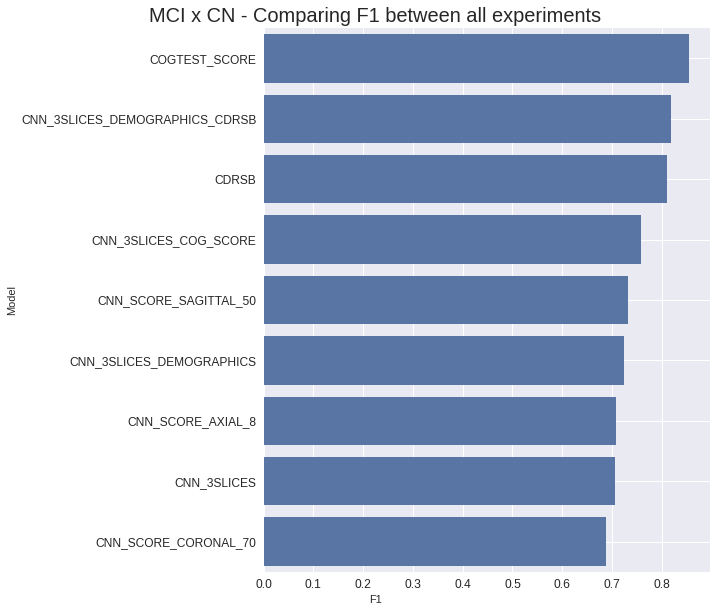

In [37]:
plot_metric_performance(df=df_test,metric='F1Score',metric_label='F1',experiment_name = 'MCI x CN')

### Metrics table

In [38]:
df_result_metrics = calculate_metrics_on_datasets(models=ensemble_experiments_best,datasets = datasets,df_rocs=df_rocs,label='DIAGNOSIS',verbose=0)
df_test = df_result_metrics.query("Set == 'Test'").drop(["Conf_Mat",'Set'],axis=1)
df_test

,Model,Auc,F1Score,Accuracy,Precision,Recall,Prediction_Threshold
10,CNN_3SLICES_COG_SCORE,0.960,0.759,0.871,0.649,0.914,0.000
11,CNN_3SLICES,0.917,0.705,0.846,0.615,0.827,0.306
12,CNN_3SLICES_DEMOGRAPHICS,0.915,0.724,0.852,0.617,0.877,0.000
13,CNN_3SLICES_DEMOGRAPHICS_CDRSB,0.982,0.818,0.909,0.740,0.914,0.457
14,CDRSB,0.978,0.810,0.896,0.681,1.000,0.500


In [39]:
df_all_metrics = pd.pivot_table(data=df_result_metrics.drop(['Conf_Mat'],axis=1),index=['Model','Set'])
df_all_metrics = df_all_metrics.sort_index(key=lambda x: x.map({
                                                'CNN_3SLICES':0,
                                                'CNN_3SLICES_COG_SCORE':1,
                                                'CNN_3SLICES_DEMOGRAPHICS':2,
                                                'CNN_3SLICES_DEMOGRAPHICS_CDRSB':3,
                                                'CDRSB':4,
                                                'Train':0,
                                                'Validation':1}))
df_all_metrics

Accuracy    Auc  F1Score  \
Model                          Set                                    
CNN_3SLICES                    Train          1.000  1.000    1.000   
                               Validation     0.845  0.914    0.729   
                               Test           0.846  0.917    0.705   
CNN_3SLICES_COG_SCORE          Train          1.000  1.000    1.000   
                               Validation     0.854  0.958    0.748   
                               Test           0.871  0.960    0.759   
CNN_3SLICES_DEMOGRAPHICS       Train          1.000  1.000    1.000   
                               Validation     0.839  0.918    0.725   
                               Test           0.852  0.915    0.724   
CNN_3SLICES_DEMOGRAPHICS_CDRSB Train          1.000  1.000    1.000   
                               Validation     0.899  0.972    0.804   
                               Test           0.909  0.982    0.818   
CDRSB                          Train          0.905  0.968    0.825   
                               Validation     0.893  0.963    0.808   
                               Test           0.896  0.978    0.810   

                                           Precision  Prediction_Threshold  \
Model                          Set                                           
CNN_3SLICES                    Train           1.000                 0.664   
                               Validation      0.612                 0.306   
                               Test            0.615                 0.306   
CNN_3SLICES_COG_SCORE          Train           1.000                 0.999   
                               Validation      0.621                 0.000   
                               Test            0.649                 0.000   
CNN_3SLICES_DEMOGRAPHICS       Train           1.000                 1.000   
                               Validation      0.600                 0.000   
                               Test            0.617                 0.000   
CNN_3SLICES_DEMOGRAPHICS_CDRSB Train           1.000                 0.308   
                               Validation      0.725                 0.457   
                               Test            0.740                 0.457   
CDRSB                          Train           0.705                 0.500   
                               Validation      0.690                 0.500   
                               Test            0.681                 0.500   

                                           Recall  
Model                          Set                 
CNN_3SLICES                    Train        1.000  
                               Validation   0.902  
                               Test         0.827  
CNN_3SLICES_COG_SCORE          Train        1.000  
                               Validation   0.939  
                               Test         0.914  
CNN_3SLICES_DEMOGRAPHICS       Train        1.000  
                               Validation   0.915  
                               Test         0.877  
CNN_3SLICES_DEMOGRAPHICS_CDRSB Train        1.000  
                               Validation   0.902  
                               Test         0.914  
CDRSB                          Train        0.994  
                               Validation   0.976  
                               Test         1.000

### Confusion Matrix

In [40]:
for i,item in df_result_metrics.iterrows():
    print(item['Model'] + ' - ' + item['Set'])
    print(pd.DataFrame(item['Conf_Mat']))
    print('---------------------------')

CNN_3SLICES_COG_SCORE - Train
     0    1
0  554    0
1    0  161
---------------------------
CNN_3SLICES - Train
     0    1
0  554    0
1    0  161
---------------------------
CNN_3SLICES_DEMOGRAPHICS - Train
     0    1
0  554    0
1    0  161
---------------------------
CNN_3SLICES_DEMOGRAPHICS_CDRSB - Train
     0    1
0  554    0
1    0  161
---------------------------
CDRSB - Train
     0    1
0  487   67
1    1  160
---------------------------
CNN_3SLICES_COG_SCORE - Validation
     0   1
0  226  47
1    5  77
---------------------------
CNN_3SLICES - Validation
     0   1
0  226  47
1    8  74
---------------------------
CNN_3SLICES_DEMOGRAPHICS - Validation
     0   1
0  223  50
1    7  75
---------------------------
CNN_3SLICES_DEMOGRAPHICS_CDRSB - Validation
     0   1
0  245  28
1    8  74
---------------------------
CDRSB - Validation
     0   1
0  237  36
1    2  80
---------------------------
CNN_3SLICES_COG_SCORE - Test
     0   1
0  243  40
1    7  74
----------------